# Motivation
Disaster damage assessment is a critical task in geospatial analysis, requiring accurate identification of changes in affected areas. Current segmentation models, such as SAM (Segment Anything Model), are effective but require enhanced guidance to adapt to diverse scenarios, especially when comparing pre-disaster and post-disaster imagery. Vision-language models, like LLaVa, offer robust multimodal reasoning but lack the ability to make contrastive conclusions directly from image pairs.

To address these datasettaset/llenges, the project focuses on developing a foundation model that integrates contrastive learning capabilities into the LLaVa framework. By enabling the model to reason contrastively, it can better guide segmentation tasks, improving its adaptability and precision in generating segmentation masks for disaster damage assessment. The ultimate goal is to create a proof of concept (POC) that demonstrates the feasibility of incorporating contrastive reasoning into geospatial analysis for real-world applications.

# Approach 
## LLaVA Architecture
![image0.png](./Report_Images/LLaVa.png)
## Initial (Naive) Approach
### Prompt
We used the same prompt throughout the project: "Are given two images are similar ?"
### Concatenating the Images
Our initial approach to enable the model to compare a pair of images involved simply concatenating the two images and feeding the combined input through the Vision pipeline.
| S.no | Prompt                      | Image1 | GT  |
|------|-----------------------------|--------|-----|
| 1    | "Are given two images are similar?" | ![image.png](./Report_Images/Image_concat.jpg) | No |
| 2    | "Are given two images are similar?" | ![image-2.png](./Report_Images/Image_concat_same.jpg) | Yes |

However, the model performed poorly with this approach with only a 53% accuracy.
## Splitting the Images
In this approach, we modified the LLaVa architecture to accept two images alongside the prompt. Each image is processed independently through the Vision pipeline, and the resulting tokens are subsequently concatenated and fed to the LLM.
| S.no | Prompt                      | Image1 | Image2 | GT  |
|------|-----------------------------|--------|--------|-----|
| 1    | "Are given two images are similar?" | ![image.png](./Report_Images/Image1.jpg) | ![image-2.png](./Report_Images/Image2.jpg) | No  |
| 2    | "Are given two images are similar?" | ![image-3.png](./Report_Images/Image3.jpg) | ![image-3.png](./Report_Images/Image3.jpg) | Yes |
## Augmenting the same Image
A limitation of these approaches is that the LLM does not derive any meaningful conclusions. To address this, we improved the model by making Image 2 more similar to Image 1 (instead of using entirely unrelated images, as shown above) through data augmentation. Also notice in the second row, we used an augmented image in both Image1 and Image2 so encourage the model to pay attention to both images. Additionally, we enhanced the Ground Truths to be more descriptive by specifying the type of augmentation applied. This adjustment prevents the LLM from solely focusing on the augmented (e.g., blurred) Image 2 and concluding that it is different, without properly considering its relationship to Image 1.
| S.no | Prompt                      | Image1 | Image2 | GT  |
|------|-----------------------------|--------|--------|-----|
| 1    | "Are given two images are similar?" | ![image_1.png](.\Report_Images\Same.png) | ![image_s.png](.\Report_Images\Same.png) | Yes, Comments: Both the images are similar  |
| 2    | "Are given two images are similar?" | ![image_1.png](.\Report_Images\Cropped.png) | ![image_s.png](.\Report_Images\Cropped.png) | Yes, Comments: Both the images are similar |
| 3    | "Are given two images are similar?" | ![image.png](.\Report_Images\Blurred_og.png) | ![image_b.png](.\Report_Images\Blurred_blur.png) | No, Comments: when compared with the first image, the second image is **blurred** |
| 4    | "Are given two images are similar?" | ![image_0.png](.\Report_Images\Cropped_og.png) | ![image_c.png](.\Report_Images\Cropped_crop.png) | No, Comments: when compared with the first image, the second image is **cropped** |
## Final Approach
In the final approach, we also added more augmentations to increase the variety of differences for the model to predict.
| S.no | Prompt                      | Image1 | Image2 | GT  |
|------|-----------------------------|--------|--------|-----|
| 1    | "Are given two images are similar?" | ![image_1.png](.\Report_Images\Same.png) | ![image_s.png](.\Report_Images\Same.png) | Yes, Comments: Both the images are similar  |
| 2    | "Are given two images are similar?" | ![image_1.png](.\Report_Images\Cropped.png) | ![image_s.png](.\Report_Images\Cropped.png) | Yes, Comments: Both the images are similar |
| 3    | "Are given two images are similar?" | ![image.png](.\Report_Images\Blurred_og.png) | ![image_b.png](.\Report_Images\Blurred_blur.png) | No, Comments: when compared with the first image, the second image is **blurred** |
| 4    | "Are given two images are similar?" | ![image_0.png](.\Report_Images\Cropped_og.png) | ![image_c.png](.\Report_Images\Cropped_crop.png) | No, Comments: when compared with the first image, the second image is **cropped** |
| 5    | "Are given two images are similar?" | ![image_0.png](.\Report_Images\Decolorized_og.png) | ![image_c.png](.\Report_Images\Decolorized_decolor.png) | No, Comments: when compared with the second image, the first image is **decolorized**|
| 6    | "Are given two images are similar?" | ![image_0.png](.\Report_Images\Flipped_og.png) | ![image_c.png](.\Report_Images\Flipped_flip.png) | No, Comments: when compared with the second image, the first image is **flipped**|

# Data
We used images from the Multimodal-Fatima dataset: https://huggingface.co/Multimodal-Fatima. However, we constructed our own dataset using these images. Below is a very similar to generate examples of our dataset. The data is fed into the model dynamically, while also generating the ground truths.

In [14]:
!pip install pillow
!pip install matplotlib
!pip install torch torchvision torchaudio

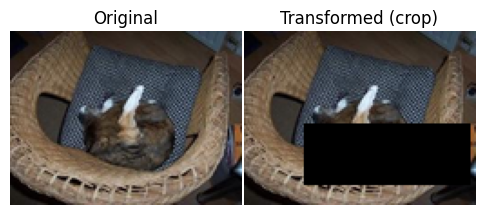

Ground truth: No, Comments: when compared with the second image, the first image is cropped


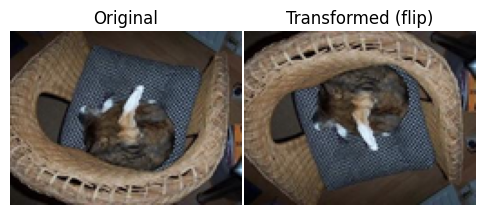

Ground truth: No, Comments: when compared with the second image, the first image is flipped


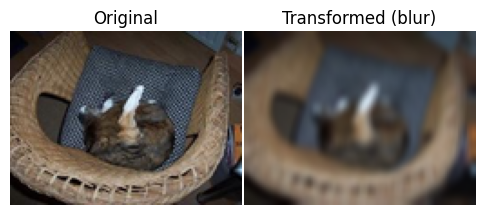

Ground truth: No, Comments: when compared with the second image, the first image is blurred


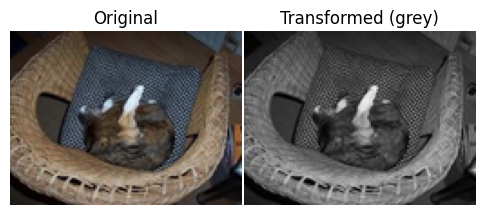

Ground truth: No, Comments: when compared with the second image, the first image is decolorized


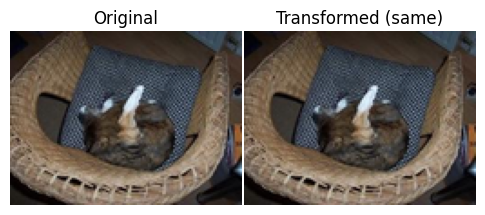

Ground truth: Yes, Comments: Both the images are similar


In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

torch.manual_seed(0)

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    # Resize the image to half its original size
    new_width = image.width // 2
    new_height = image.height // 2
    image = image.resize((new_width, new_height), Image.LANCZOS)
    return image

def apply_transformation(image, transformation):
    if transformation == "blur":
        transform = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        return transform(image)
    elif transformation == "crop":
        # Convert PIL image to tensor
        image_tensor = T.ToTensor()(image)
        eraser = T.RandomErasing(
            p=1.0,  
            scale=(0.02, 0.33),  
            ratio=(0.3, 3.3),   
            value=0  
        )
        # Apply Random Erasing
        image_tensor_erased = eraser(image_tensor)
        image_erased = T.ToPILImage()(image_tensor_erased)
        return image_erased
    elif transformation == "flip":
        transform = T.RandomVerticalFlip(p=1.0)
        return transform(image)
    elif transformation == "grey":
        transform = T.Grayscale(num_output_channels=3)
        return transform(image)
    else:
        return image

def visualize_image(image_path):
    transformations = ["crop", "flip", "blur", "grey", "same"]
    image = load_image(image_path)

    for i, transformation in enumerate(transformations):
        image_transformed = apply_transformation(image, transformation)
        
        # Display the original and transformed images
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(image_transformed)
        plt.title(f"Transformed ({transformation})")
        plt.axis("off")
        plt.subplots_adjust(hspace=0.01, wspace=0.01)
        plt.show()
        
        transformations_dict = {"crop": "cropped", "flip": "flipped", "grey": "decolorized", "blur": "blurred"}
        if transformation == "same":
            print("Ground truth: Yes, Comments: Both the images are similar")
        else:
            print(f"Ground truth: No, Comments: when compared with the second image, the first image is {transformations_dict[transformation]}")

if __name__ == "__main__":
    # Replace with the path to your specific image
    image_path = "./Report_Images/Image3.jpg"
    if os.path.exists(image_path):
        visualize_image(image_path)
    else:
        print(f"Image not found: {image_path}")


# Experimental Setup
We used class-wise measurements to evaluate the results. We have 5 classes that the LLM can predict. We extracted the last word of the prediction and compared to the ground truth that was generated dynamically. Below is a subset of the lines from the output file.

Note that we extracted the last word of the prediction/ground truths since we designed our phrases as below:

- Yes, Comments: Both the images are **similar**
- No, Comments: when compared with the second image, the first image is **[transformation]**

Since we are working with a classification problem we used precision, recall, accuracy, and f1-score to evaluate our results. We get out evaluation scores by comparing the prediction column to the ground truth column. Below is a toy example of how this is done.

```blurred blurred
down flipped
similar similar
decolorized decolorized
decolorized decolorized
similar similar
down flipped
blurred blurred
similar similar

In [16]:
!pip install pandas
!pip install scikit-learn

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

data = """
blurred blurred
down flipped
similar similar
decolorized decolorized
decolorized decolorized
similar similar
down flipped
blurred blurred
similar similar
"""

# Parse the data into a DataFrame
lines = data.strip().split("\n")
predictions, ground_truths = zip(*(line.split() for line in lines))

# Convert to DataFrame for analysis
df = pd.DataFrame({'Predictions': predictions, 'Ground Truths': ground_truths})

# Calculate evaluation metrics
conf_matrix = confusion_matrix(df['Ground Truths'], df['Predictions'])
class_report = classification_report(df['Ground Truths'], df['Predictions'], zero_division=0)
accuracy = accuracy_score(df['Ground Truths'], df['Predictions'])

print(conf_matrix)
print(class_report)




[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 3]]
              precision    recall  f1-score   support

     blurred       1.00      1.00      1.00         2
 decolorized       1.00      1.00      1.00         2
        down       0.00      0.00      0.00         0
     flipped       0.00      0.00      0.00         2
     similar       1.00      1.00      1.00         3

    accuracy                           0.78         9
   macro avg       0.60      0.60      0.60         9
weighted avg       0.78      0.78      0.78         9



# Results

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

out_file = 'output.txt'
with open(out_file, 'r') as file:
    lines = file.readlines()

# Parse predictions and ground truths
predictions, ground_truths = zip(*(line.strip().split() for line in lines))

# Convert to DataFrame for analysis
df = pd.DataFrame({'Predictions': predictions, 'Ground Truths': ground_truths})

# Calculate evaluation metrics
conf_matrix = confusion_matrix(df['Ground Truths'], df['Predictions'])
class_report = classification_report(df['Ground Truths'], df['Predictions'], zero_division=0)
accuracy = accuracy_score(df['Ground Truths'], df['Predictions'])

print(conf_matrix)
print(class_report)



[[ 40   0   0   0   0   4]
 [  0  32   0   0   0   0]
 [  0   0  38   0   1   3]
 [  0   0   0   0   0   0]
 [  1   0   0  15  25   0]
 [  0   0   0   0   0 141]]
              precision    recall  f1-score   support

     blurred       0.98      0.91      0.94        44
     cropped       1.00      1.00      1.00        32
 decolorized       1.00      0.90      0.95        42
        down       0.00      0.00      0.00         0
     flipped       0.96      0.61      0.75        41
     similar       0.95      1.00      0.98       141

    accuracy                           0.92       300
   macro avg       0.81      0.74      0.77       300
weighted avg       0.97      0.92      0.94       300



# Analysis of Results

## Raw Results

Overall, we successfully modified the LLaVa architecture and allowed it to accurately tell the difference between 2 images.

In [19]:
!pip install seaborn

C:\Users\rajsh\AppData\Local\Temp\ipykernel_27928\3030472658.py:9: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


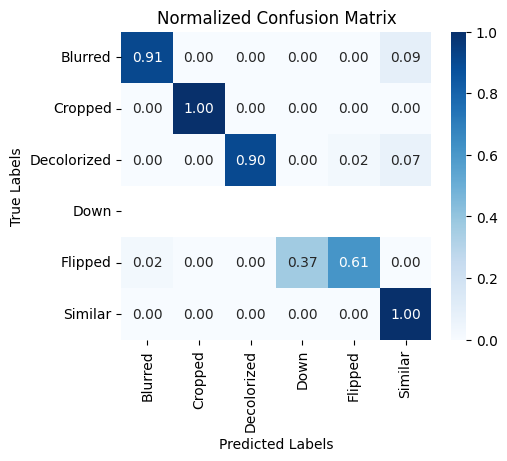

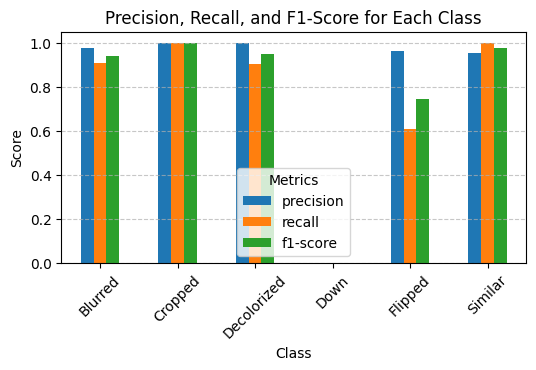

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class labels
class_labels = ["Blurred", "Cropped", "Decolorized", "Down", "Flipped", "Similar"]

# Normalize the confusion matrix for visualization
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
class_report = classification_report(df['Ground Truths'], df['Predictions'], zero_division=0)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Bar plot for precision, recall, and F1-score
metrics = classification_report(df['Ground Truths'], df['Predictions'], output_dict=True, zero_division=0)
class_metrics = pd.DataFrame(metrics).T.drop(["accuracy", "macro avg", "weighted avg"])

# Plot Precision, Recall, and F1-score
class_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(6, 3))
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Investigating the issue with "flipped" and "down"

Looking at the full output of the model, we can see why some of the extracted predictions are "down". The LLM adds "upside down" after "flipped" since these words go together very often. Below is the case where this happens.

`No, Comments: When compared with the first image, the second image is flipped upside down`

Note that "down" is NOT part of the ground truths. Furthermore, the model performs very well with four of the five classes. However, in the case where the image was vertically flipped, the model outputs a different phrase than what we have trained it for. This is the main reason why the performance seems to be especially bad for the "flipped" class.

              precision    recall  f1-score   support

     blurred       0.98      0.91      0.94        44
     cropped       1.00      1.00      1.00        32
 decolorized       1.00      0.90      0.95        42
     flipped       0.98      0.98      0.98        41
     similar       0.95      1.00      0.98       141

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



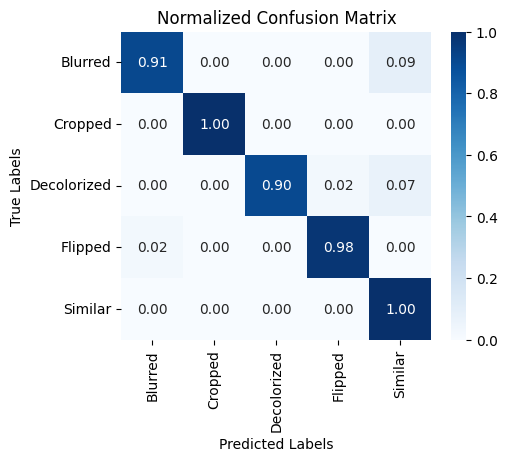

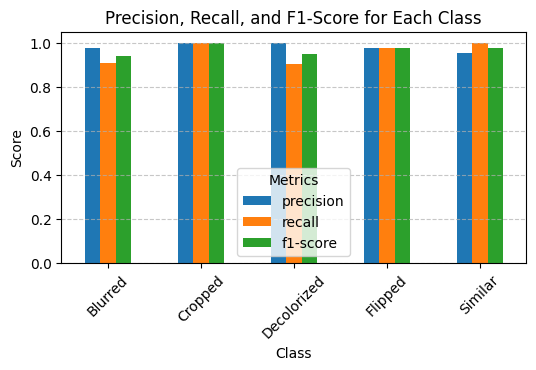

In [21]:
# Combine "down" and "flipped" into a single class in both predictions and ground truths
df_combined = df.copy()
df_combined['Predictions'] = df_combined['Predictions'].replace("down", "flipped")

# Recalculate confusion matrix, classification report, and accuracy
conf_matrix_combined = confusion_matrix(df_combined['Ground Truths'], df_combined['Predictions'])
class_report_combined = classification_report(df_combined['Ground Truths'], df_combined['Predictions'], zero_division=0)
accuracy_combined = accuracy_score(df_combined['Ground Truths'], df_combined['Predictions'])
print(class_report_combined)
# Define class labels
class_labels = ["Blurred", "Cropped", "Decolorized", "Flipped", "Similar"]

# Normalize the confusion matrix for visualization
conf_matrix_normalized = conf_matrix_combined.astype('float') / conf_matrix_combined.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Bar plot for precision, recall, and F1-score
metrics = classification_report(df_combined['Ground Truths'], df_combined['Predictions'], output_dict=True, zero_division=0)
class_metrics = pd.DataFrame(metrics).T.drop(["accuracy", "macro avg", "weighted avg"])

# Plot Precision, Recall, and F1-score
class_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(6, 3))
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


When we treat "down" as the correct prediction for "flipped" and we see that the evaluation metrics drastically increase.

The most confused classes seem to be betwee "similar" and "decolorized" or "blurred". This is because the images are most similar in these two cases compared to when we have a patch missing or when the image is flipped.

## Swapping image order

To check the robustness of the model, we tested if the model performs well if we have the augmented image in Image1 and the original image in Image2.

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

out_file = 'output_test.txt'
with open(out_file, 'r') as file:
    lines = file.readlines()

predictions, ground_truths = zip(*[line.split() for line in lines])

# Converting to DataFrame for easier manipulation
df = pd.DataFrame({'Prediction': predictions, 'GroundTruth': ground_truths})

# Marking invalid predictions as incorrect
valid_classes = {"cropped", "blurred", "similar", "decolorized", "flipped"}
df['ValidPrediction'] = df['Prediction'].apply(lambda x: x if x in valid_classes else 'wrong')

# Metrics calculation
accuracy = accuracy_score(df['GroundTruth'], df['ValidPrediction'])
conf_matrix = confusion_matrix(df['GroundTruth'], df['ValidPrediction'], labels=list(valid_classes) + ['wrong'])
class_report = classification_report(df['GroundTruth'], df['ValidPrediction'], labels=list(valid_classes) + ['wrong'], zero_division=0)


print(accuracy)
print(conf_matrix)
print(class_report)


0.57
[[  0   2   2  24   0   0]
 [  0 150   0   0   0   0]
 [  0   0   2  41   0   1]
 [  0   3   5  17   4   4]
 [  0   0   2  35   2   6]
 [  0   0   0   0   0   0]]
              precision    recall  f1-score   support

 decolorized       0.00      0.00      0.00        28
     similar       0.97      1.00      0.98       150
     flipped       0.18      0.05      0.07        44
     blurred       0.15      0.52      0.23        33
     cropped       0.33      0.04      0.08        45
       wrong       0.00      0.00      0.00         0

    accuracy                           0.57       300
   macro avg       0.27      0.27      0.23       300
weighted avg       0.58      0.57      0.54       300



We see the the model does poorly when we swap the image, this is probably because our dataset's design. When the images are not similar, the first image is always the original one and the second image is always the augmented one.

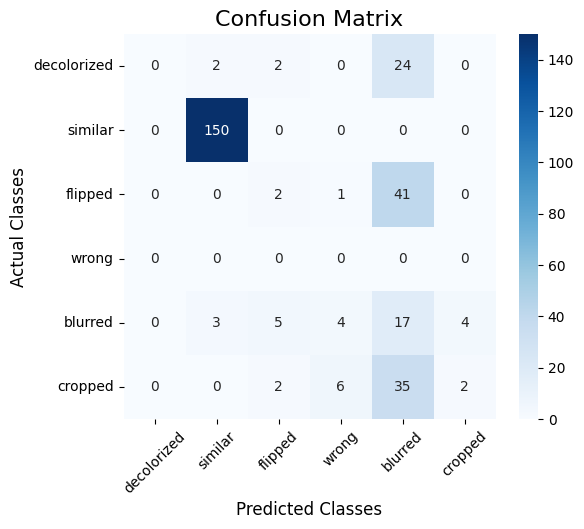

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Example data
ground_truth = df['GroundTruth']
valid_prediction = df['ValidPrediction']

# Dynamically determine labels
labels = list(set(ground_truth).union(set(valid_prediction)))

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, valid_prediction, labels=labels)

# Plotting the confusion matrix dynamically
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Titles and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("Actual Classes", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


The model performs equally as well for the similar images as expected but is not able to perform well for other classes. Moreover, the model outputs more invalid reponses (represented by the "wrong" class). A possible solution to this is discussed in the "Future Work" section below.

For more information regarding the performance of different approaches we have, please take a look at this document:
[Experimental Trials](https://sfu-team-r6nizx74.atlassian.net/wiki/external/ZDA1MDRkYWRkOTUwNDI5ZWJhMWJlNWYzOWNmNTY1MjY)


# Future Work

#### Image Separation Token
- A separation token clearly indicates the boundary between two images, helping the model distinguish features belonging to each image.
- Without clear separation, features from one image might interfere with those of the other. For example, if one image is mostly grayscale with some patches of color and the images are augmented to full grayscale, the model might struggle to identify the boundary between them.

#### Training Adjustments
1. Change "Similar" to "Identical"
    - Using "identical" during training can reduce confusion when images are blurred or decolorized, especially since we are working with an LLM.
2. Randomize Image Order
    - During training, alternate the order of augmented and original images. For instance, sometimes assign the augmented image as "image 1" and the original as "image 2," and vice versa. This migh fix the issue we tested above.

#### Improved Evaluation Metrics
- Ensure evaluation considers whether a specific keyword is present in the phrase, rather than just extracting the last term.
- Use metrics that evaluate not only whether the model correctly classifies images as "similar" or "not similar" but also account for the type of difference identified.

#### Multiple Augments
- Try increasing the model's capability by training it using images with multiple augments. The model might be able to describe mutliple differences on the same image.